Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),

Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),

Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),

Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),

Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),

Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),

Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),

Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),


11 to 18 => 18-11+1=8 classes + 1 background class = 9 classes in total

# Import libraries

In [1]:
!git clone https://github.com/mcordts/cityscapesScripts.git

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 674, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 674 (delta 195), reused 184 (delta 163), pack-reused 427 (from 1)
Receiving objects: 100% (674/674), 837.07 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
# import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
from torchvision.ops import masks_to_boxes
from torchvision import tv_tensors
import torchvision.transforms.v2 as T

from cityscapesScripts.cityscapesscripts.helpers.labels import id2label, trainId2label, labels, name2label

# Helper functions

In [4]:

        
id_to_trainId_map = torch.zeros((34,), dtype=torch.long)
class_names = {}
valid_label = [24, 25, 26, 27, 28, 31, 32, 33]
valid_label_to_trainLabel = {
    24: 0, 
    25: 1, 
    26: 2, 
    27: 3, 
    28: 4, 
    31: 5, 
    32: 6, 
    33: 7
}
trainLabel_to_valid_label = {
    0: 24, 
    1: 25, 
    2: 26, 
    3: 27, 
    4: 28, 
    5: 31, 
    6: 32, 
    7: 33
}
for label in labels:
    if label.id in valid_label:
        id_to_trainId_map[label.id] = valid_label_to_trainLabel[label.id] # 11..18 ~ 1..8 (0 for background) 
        class_names[valid_label_to_trainLabel[label.id]] = label.name

class_id_to_name = {}
class_id_to_color = {}
class_trainId_to_color = {}
colors = []
for l in labels:
    class_id_to_name[l[2]] = l[0]
    class_id_to_color[l[2]] = l[-1]
    colors.append(l[-1])
    if 11 <= l[2] and l[2] <= 18:
        class_trainId_to_color[l[2]-11] = l[-1] ####################### Essential for 8 class

# class_trainId_to_color[0] = (0, 0, 0) # not a bg here
print(class_trainId_to_color)
def convert_instance_to_semantic(instance_masks, instance_labels):
    """
    Converts an instance mask of shape [N, H, W] to a semantic mask of shape [H, W].
    
    This is done by "painting" the class ID from instance_labels onto the
    corresponding binary mask from instance_masks.
    """
    if instance_masks.ndim != 3 or instance_labels.ndim != 1:
        raise ValueError(f"Expected shapes [N, H, W] and [N], but got "
                         f"{instance_masks.shape} and {instance_labels.shape}")
    
    # Reshape labels to [N, 1, 1] to allow broadcasting
    reshaped_labels = instance_labels.view(-1, 1, 1)
    
    # Multiply masks by their labels and take the max to handle overlaps
    # The result is a single [H, W] tensor where each pixel has the class ID
    semantic_mask = torch.max(instance_masks.float() * reshaped_labels, dim=0)[0]
    
    return semantic_mask.long()

def colorize_mask(mask, color_dict):
    """Converts a HxW segmentation mask of class indices to a 3xHxW RGB image."""
    # Ensure mask is on CPU and is a numpy array
    mask_np = mask.cpu().numpy()
    rgb_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    
    present_classes = np.unique(mask_np)
    for class_id in present_classes:
        if class_id in color_dict:
            indices = (mask_np == class_id)
            # Assign the corresponding color
            rgb_mask[indices] = color_dict[class_id]
            
    return torch.from_numpy(rgb_mask).permute(2, 0, 1)

{0: (220, 20, 60), 1: (255, 0, 0), 2: (0, 0, 142), 3: (0, 0, 70), 4: (0, 60, 100), 5: (0, 80, 100), 6: (0, 0, 230), 7: (119, 11, 32)}


# Config

In [5]:
from omegaconf import OmegaConf

def load_config(filepath):
    with open(filepath, 'r') as f:
        return OmegaConf.load(f)
    

path_cfg = load_config("/kaggle/input/segment-city/path_config.yaml")
train_cfg = load_config("/kaggle/input/segment-city/train_config.yaml")
model_cfg = load_config("/kaggle/input/segment-city/model_config.yaml")

In [6]:
path_cfg.dataset_path = "/kaggle/input/cityscapes"
config = OmegaConf.merge(path_cfg, train_cfg, model_cfg)

config.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model

## UNet

In [7]:
import torch
import torch.nn as nn
from torch.utils.checkpoint import checkpoint

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, X):
        return self.double_conv(X)

class DownLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, X):
        return self.maxpool_conv(X)

class UpLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, X, C):
        X = self.up(X)
        diffY = C.size()[2] - X.size()[2]
        diffX = C.size()[3] - X.size()[3]

        X = nn.functional.pad(X, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        X = torch.cat([C, X], dim = 1)
        return self.conv(X)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, n_channels, n_classes) -> None:
        super(UNET, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inp = DoubleConv(n_channels, 64)
        self.down1 = DownLayer(64, 128)
        self.down2 = DownLayer(128, 256)
        self.down3 = DownLayer(256, 512)
        self.down4 = DownLayer(512, 1024)

        self.up1 = UpLayer(1024, 512)
        self.up2 = UpLayer(512, 256)
        self.up3 = UpLayer(256, 128)
        self.up4 = UpLayer(128, 64)
        self.out = OutConv(64, n_classes)

    def contracting_path(self, X):
        out1 = self.down1(X) # 128 x 280 x 280
        out2 = self.down2(out1) # 256 x 136 x 136
        out3 = self.down3(out2) # 512 x 64 x 64
        out4 = self.down4(out3) # 1024 x 28 x 28
        return out1, out2, out3, out4
    
    def expansive_path(self, c4, c3, c2, c1, c0):
        out = self.up1(c4, c3) # 512 x 52 x 52
        out = self.up2(out, c2) # 256 x 100 x 100
        out = self.up3(out, c1) # 128 x 196 x 196
        out = self.up4(out, c0) # 64 x 388 x 388
        return out
    
    def forward(self, X):
        c0 = self.inp(X) # 64 x 568 x 568
        c1, c2, c3, c4 = self.contracting_path(c0)
        e = self.expansive_path(c4, c3, c2, c1, c0)
        logits = self.out(e) # 2 x 388 x 388
        return logits

## MaskRCNN

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

def build_MaskRCNN(num_classes):
    weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    maskrcnn = maskrcnn_resnet50_fpn_v2(weights)
    
    in_features_box = maskrcnn.roi_heads.box_predictor.cls_score.in_features
    in_features_mask = maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
    
    dim_reduced = maskrcnn.roi_heads.mask_predictor.conv5_mask.out_channels
    
    maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=num_classes)
    maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=num_classes)
    return maskrcnn

## YOLOv8-seg

## Get model function

In [9]:
def build_model(model_config, num_channels=3, num_classes=20):
    if model_config.model_name.lower() == "unet":
        return UNET(num_channels, num_classes)
    elif model_config.model_name.lower() == "maskrcnn":
        return build_MaskRCNN(num_classes)
    else:
        print(f"{model_config.model_name} is currently not supported")

# Custom dataset

In [10]:
class CityscapesDataset(Dataset):
    def __init__(self, config, transform=None, split='train'):
        super().__init__()
        self.images = [] # path to leftImg8bit
        self.label_images = [] # path to labels images
        # polygon_files = [] # path to polygon files
        self.instances = [] # path to instance images
        self.config = config
        self.task = config.task
        self._transform = transform
        
        self.class_names = [label.category for label in labels]

        left8bit_path = os.path.join(self.config.dataset_path, "leftImg8bit", split)
        for city in os.listdir(left8bit_path):
            city_images = list(os.listdir(os.path.join(left8bit_path, city)))
            city_images = [os.path.join(left8bit_path, city, image) for image in city_images]
            self.images.extend(city_images)
            
        for city in os.listdir(os.path.join(self.config.dataset_path, self.config.type, split)):
            city_dir = os.path.join(self.config.dataset_path, self.config.type, split, city)
            for file in os.listdir(city_dir):
                if file.endswith("labelIds.png"):
                    self.label_images.append(os.path.join(city_dir, file))
                elif file.endswith("instanceIds.png"):
                    self.instances.append(os.path.join(city_dir, file))
                # elif file.endswith("polygons.json"):
                #     polygon_files.append(os.path.join(city_dir, file))

        self.images = np.array(sorted(self.images))
        self.label_images = np.array(sorted(self.label_images))
        
        if len(self.images) == 0:
            raise FileNotFoundError(f"No images found in {image_dir}")
        assert len(self.images) == len(self.label_images), \
            f"Mismatch between number of images and labels. Found {len(self.images)} images and {len(self.label_images)} labels."
        
        print(f"Initialized Cityscapes dataset for '{self.task}' task.")
        print(f"Found {len(self.images)} samples in split '{split}'.")
        
        # valid_idx = []
        # for idx in tqdm(range(len(self.label_images))):
        #     img = read_image(str(self.label_images[idx])).long()
        #     img_label = torch.unique(img)
        #     # just iterative search cause only 33 classes at most
        #     valid_idx.append(np.logical_and(24 <= img_label, img_label <= 33).all()) 

        # valid_idx = np.array(valid_idx)
        # self.images = self.images[valid_idx]
        # self.label_images = self.label_images[valid_idx]
        # print(f"After filtered, number of sample with labels: {len(self.images)} samples in split '{split}'.")
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load the raw RGB image
        img = read_image(str(self.images[idx]))

        # Dispatch to the correct handler based on the task
        if self.task == "semantic":
            img, target = self._get_semantic_item(idx, img)
        elif self.task == "instance":
            # img, target = self._get_instance_item(idx, img)
            print("currently not supported")
        
        # Apply transformations (e.g., augmentations, resizing)
        if self._transform:
            img, target = self._transform(img, target)
            
        return img, target

    def _get_semantic_item(self, idx, img):
        """Prepares a target for a semantic segmentation task."""
        mask = read_image(str(self.label_images[idx])).long() # Shape: [1, H, W]

        converted_mask = torch.full_like(mask, 255) 
        converted_mask[mask == -1] = 255
        valid_pixels = (24 <= mask) & (mask <= 33)
        converted_mask[valid_pixels] = id_to_trainId_map[mask[valid_pixels]]
        # print(converted_mask.shape)

        obj_ids = torch.unique(converted_mask).to(dtype=torch.uint8)
        # print(obj_ids)
        converted_mask = (converted_mask == obj_ids[:, None, None]).to(dtype=torch.long)
        # print(converted_mask.shape)
        boxes = masks_to_boxes(converted_mask)
        labels = obj_ids[:, None].to(dtype=torch.int64)
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        
        # The target for semantic segmentation is just the mask
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        valid_boxes_mask = (widths > 0) & (heights > 0)
        # print(valid_boxes_mask.shape)
        
        boxes = boxes[valid_boxes_mask]
        converted_mask = converted_mask[valid_boxes_mask]
        labels = labels[valid_boxes_mask]
        iscrowd = iscrowd[valid_boxes_mask] 

        # if 255 in labels:
        #     boxes = boxes[:-1, :]
        #     converted_mask = converted_mask[:-1,...]
        #     labels = labels[:-1]
        #     iscrowd = iscrowd[:-1] 
            
        target = {}
        target["masks"] = tv_tensors.Mask(converted_mask) # Shape: [H, W]
        target["labels"] = labels.squeeze(1) 
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=T.functional.get_size(img))
        target["iscrowd"] = iscrowd
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        return tv_tensors.Image(img), target

Initialized Cityscapes dataset for 'semantic' task.
Found 2975 samples in split 'train'.
tensor([  0,   1,   2,   4,   7, 255])
torch.Size([6, 1024, 2048])
tensor([  0,   1,   2,   4,   7, 255])


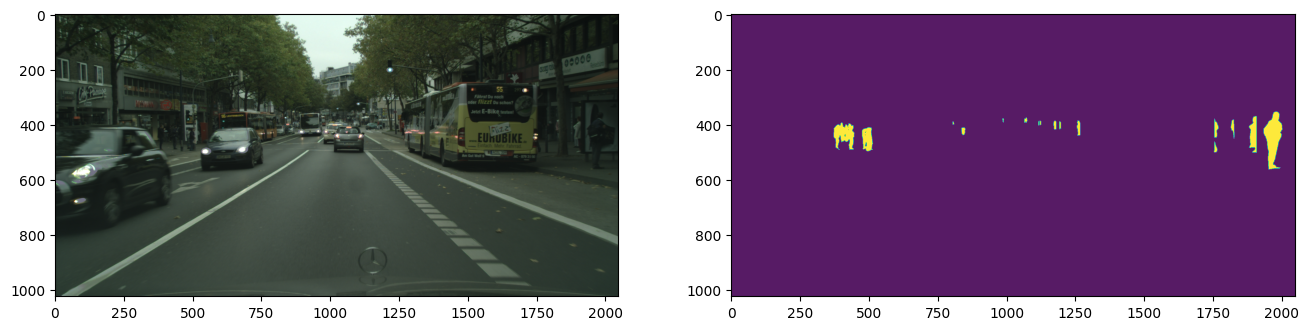

In [11]:
train_augmentation_maskrcnn = T.Compose([
    T.Resize((512,1024)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    # T.RandomSolarize(threshold=20.0),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 
val_augmentation_maskrcnn = T.Compose([
    T.Resize((512,1024)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path_cfg.task = "semantic"
train_dataset = CityscapesDataset(path_cfg)
img, target = train_dataset[12]
img_tensor = img
img = np.array(img)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(img.transpose(1, 2, 0))
print(target["labels"])
plt.subplot(122)
print(target["masks"].shape)
print(target["labels"])
plt.imshow(target["masks"][0], alpha=0.9)

BoundingBoxes([[ 373.,  354., 2001.,  563.],
               [ 441.,  401.,  457.,  474.],
               [   6.,  382., 1186.,  775.],
               [ 577.,  237., 1754.,  558.],
               [ 443.,  426.,  456.,  471.],
               [   0.,    0., 2047., 1023.]], format=BoundingBoxFormat.XYXY, canvas_size=[1024, 2048])
[  0   1   2   4   7 255]


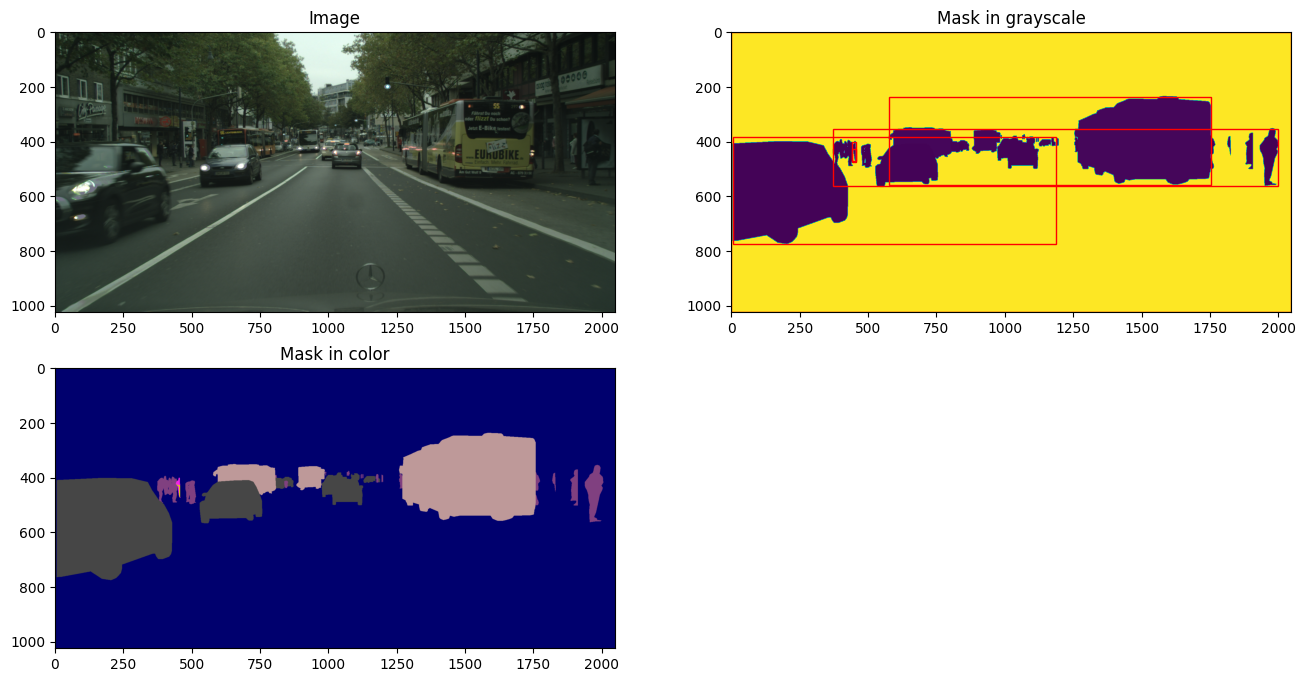

In [13]:
from matplotlib.patches import Rectangle

img, target = train_dataset[12]
img_tensor = img
img = np.array(img)
# target['boxes'] = sv.mask_to_xyxy(target['masks'])
# print(target['boxes'])
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title("Image")
plt.imshow(img.transpose(1, 2, 0))





boxes = target['boxes']
print(boxes)
rects = []
for box in boxes:
    rects.append(Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))

plt.subplot(2, 2, 2)
plt.title("Mask in grayscale")
mask_viz = convert_instance_to_semantic(target['masks'], target['labels'])
current_axes = plt.gca()
for rect in rects:
    current_axes.add_patch(rect)
plt.imshow(mask_viz)
print(np.unique(mask_viz))




plt.subplot(2, 2, 3)
plt.title("Mask in color")
mask_viz = colorize_mask(mask_viz, class_id_to_color)

# print("_".join(train_dataset.label_images[12].split('_')[:-1]) + "_polygons.json")
# with open(("_".join(train_dataset.label_images[12].split('_')[:-1]) + "_polygons.json"), "r") as f:
#     pol_data = json.load(f)
# # print(pol_data)
# bounding_boxes = [ sv.polygon_to_xyxy(p['polygon']) for p in pol_data['objects'] ]

# rects = []
# for box in bounding_boxes:
#     rects.append(Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none'))
# current_axes = plt.gca()
# for rect in rects:
#     current_axes.add_patch(rect)
plt.imshow(mask_viz.permute(1, 2, 0))

In [14]:
def collate_fn(batch):
    """
    Since the number of objects varies per image, we collate the images and targets
    into lists. The model expects a list of images and a list of targets dictionaries.
    """
    # batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    images = [item[0] for item in batch] # This will be a list of image tensors/tv_tensors.Image
    targets = [item[1] for item in batch] # This will be a list of target dictionaries
    return images, targets

def get_dataloader(dataset, config, is_train=True):
    dataloader = DataLoader(dataset, batch_size=(config.per_gpu_train_batch_size if is_train else config.per_gpu_eval_batch_size), num_workers=config.num_workers, shuffle=is_train, collate_fn = collate_fn)
    return dataloader

In [ ]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self,  epsilon: float = 1e-6):
        super().__init__()
        self.epsilon = epsilon
        
    @staticmethod
    def _calculate_dice_coeff(input_mask: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
        """
        Calculates the Dice coefficient for binary masks.
        Args:
            input_mask (Tensor): Predicted mask, expected to be probabilities (float).
            target (Tensor): Ground truth mask, expected to be binary (0 or 1, float).
            reduce_batch_first (bool): If True, computes a single Dice score over the entire batch
                                       (B, H, W) -> scalar. If False, computes Dice per item (B, H, W) -> B scores.
            epsilon (float): Small constant to avoid division by zero.
        Returns:
            Tensor: Dice coefficient.
        """
        # print(input_mask.size(), target.size())
        assert input_mask.size() == target.size(), f"Input and target must have the same size. Got {input_mask.size()} and {target.size()}"
        assert input_mask.dim() >= 2, "Input mask must have at least 2 dimensions (H, W)"
        assert input_mask.dim() == 3 or not reduce_batch_first, \
            "If reduce_batch_first is True, input_mask must be 3-dimensional (B, H, W) after potential flattening."
    
        # Determine dimensions to sum over
        if reduce_batch_first: # Sum over B, H, W
            sum_dim = (-1, -2, -3) # Assumes B, H, W for input_mask.dim() == 3, or C, H, W after flatten(0,1) from B, C, H, W
        else: # Sum over H, W (per item in batch/channel)
            sum_dim = (-1, -2)
    
        inter = 2 * (input_mask * target).sum(dim=sum_dim)  # 2 * |A giao B|
        sets_sum = input_mask.sum(dim=sum_dim) + target.sum(dim=sum_dim)  # |A| + |B|
        
        # Handle cases where sets_sum is 0 to avoid NaNs, set dice to 1 if both are empty (inter=0, sets_sum=0)
        sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
        #print("sets_sum = ", sets_sum)
        dice = (inter + epsilon) / (sets_sum + epsilon)  # (2 * |A giao B| + eps) / (|A| + |B| + eps)
        return dice.mean()
    
    def _multiclass_dice_coeff(self, input_mask: Tensor, target: Tensor, reduce_batch_first: bool = False):
        """
        Calculates the average Dice coefficient across all classes for multi-class segmentation.
        Flattens (B, C, H, W) to (B*C, H, W) and calls dice_coeff.
        Args:
            input_mask (Tensor): Predicted masks, shape (B, C, H, W), probabilities (float).
            target (Tensor): Ground truth masks, shape (B, C, H, W), one-hot encoded (float).
            reduce_batch_first (bool): If True, computes a single Dice score over the entire (B*C) flattened batch.
                                       If False, computes Dice per (B*C) item.
            epsilon (float): Small constant to avoid division by zero.
        Returns:
            Tensor: Average Dice coefficient.
        """
        # Flatten N and C dimensions to treat each class in each batch as a separate binary mask
        # Shape changes from (N, C, H, W) to (N*C, H, W)
        return self._calculate_dice_coeff(
            input_mask.flatten(0, 1), 
            target.flatten(0, 1), 
            reduce_batch_first, 
            self.epsilon
        )

    def _binary_dice_coeff(self, input_mask: Tensor, target: Tensor, reduce_batch_first: bool) -> Tensor:
        return self._calculate_dice_coeff(
            input_mask, 
            target, 
            reduce_batch_first, 
            self.epsilon
        )
    
    def forward(self, input_mask: Tensor, target: Tensor, multiclass: bool = False):
        """
        Calculates the Dice loss (objective to minimize) between 0 and 1.
        Args:
            input_mask (Tensor): Predicted mask (logits or probabilities) (B, C, H, W).
            target (Tensor): Ground truth mask (binary or one-hot encoded)  (B, C, H, W).
            multiclass (bool): If True, uses multiclass_dice_coeff; otherwise, uses dice_coeff.
        Returns:
            Tensor: Dice loss (1 - Dice_coefficient).
        """
        # Note: If input_mask are logits, they should be passed through softmax/sigmoid before
        # being used with dice_coeff/multiclass_dice_coeff for optimal results,
        # as these functions expect probabilities or binary masks.
        fn = self._multiclass_dice_coeff if multiclass else self._binary_dice_coeff
        
        if multiclass:
            input_probs = F.softmax(input_mask, dim=1)
            if input_probs.shape[1] > target.shape[1]:
                input_probs = input_probs[:, 1:, ...]
        elif input_mask.dim() == target.dim(): # Binary case, e.g., (N, H, W)
            input_probs = torch.sigmoid(input_mask)
        else:
            input_probs = input_mask
    
        return 1 - fn(input_probs, target, reduce_batch_first=True)

class FocalLoss(nn.Module):
    def __init__(self, ignore_index=0, alpha=0.25, gamma=2, reduction='mean'):
        super().__init__()
        self.ignore_index = ignore_index
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        inputs: Logits from model (B, C, H, W).
        targets: Ground truth masks (B, H, W).
        """
        if targets.size() == 4 and targets.shape[1] == 1:
            targets = targets.squeeze(1).long()

        CE_loss = F.cross_entropy(inputs, targets, reduction=self.reduction, ignore_index=self.ignore_index)
        # focal loss = BCE * a * (1 - e^(-BCE))^y 
        pt = torch.exp(-CE_loss) 
        focal_loss = self.alpha * (1 - pt) ** self.gamma * CE_loss

        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Combined Dice + Focal + CE Loss
class DiceFocalCELoss(nn.Module):
    def __init__(self, weights = [0.35, 0.3, 0.35], ignore_index=0, alpha=0.35, gamma=3, reduction='mean'):
        super().__init__()
        self.weights = weights
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss(ignore_index=ignore_index, alpha=alpha, gamma=gamma, reduction=reduction)

    def forward(self, inputs, onehot_targets, semantic_targets):
        """
        inputs: Logits from model (B, C, H, W).
        onehot_targets: Ground truth masks (B, C-1, H, W).
        semantic_targets: Ground truth masks (B, H, W).
        """
        inputs = inputs.float()
        onehot_targets = onehot_targets.long()
        semantic_targets = semantic_targets.long()

        losses = {
            'ce': 0.0,
            'dl': 0.0,
            'fc': 0.0
        }
        losses['ce'] = self.weights[0] * self.ce_loss(inputs, semantic_targets)  
        losses['dl'] = self.weights[1] * self.dice_loss(inputs, onehot_targets, multiclass=True)
        losses['fc'] = self.weights[2] * self.focal_loss(inputs, semantic_targets)
        
        return losses
    
        

In [17]:
def show_loss_graph(losses):
    plt.figure(figsize=(12,8))
    plt.title("Loss over training")
    plt.plot(losses, color='b', linewidth=2)
    
    plt.xlabel("steps")
    plt.ylabel("loss value")
    plt.xlim(0, len(losses)-1)
    
    plt.grid()
    plt.legend()
    plt.show()

def show_lr_graph(lrs):
    plt.figure(figsize=(12,8))
    plt.title("Learning rate over training")
    plt.plot(lrs, color='r', linewidth=2)
    
    plt.xlabel("steps")
    plt.ylabel("learning rate")
    plt.xlim(0, len(lrs)-1)
    
    plt.grid()
    plt.legend()
    plt.show()

## Training UNet

In [18]:
train_augmentation_unet = T.Compose([
    T.Resize((512,1024)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    # T.RandomSolarize(threshold=20.0),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 
val_augmentation_unet = T.Compose([
    T.Resize((512,1024)),
    T.ToImage(), T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
def collate_fn(batch):
    """
    Since the number of objects varies per image, we collate the images and targets
    into lists. The model expects a list of images and a list of targets dictionaries.
    """
    # batch is a list of tuples: [(img1, target1), (img2, target2), ...]
    images = [item[0] for item in batch] # This will be a list of image tensors/tv_tensors.Image
    targets = [item[1] for item in batch] # This will be a list of target dictionaries
    return images, targets

def get_dataloader(dataset, config, is_train=True):
    dataloader = DataLoader(dataset, batch_size=config.per_gpu_train_batch_size, num_workers=config.num_workers, shuffle=is_train, collate_fn = collate_fn)
    return dataloader

In [20]:
test_dataset_for_viz = CityscapesDataset(path_cfg, val_augmentation_unet, split='val')
image_idx_to_viz = 12
original_image_viz = read_image(test_dataset_for_viz.images[image_idx_to_viz]).to(torch.uint8)

Initialized Cityscapes dataset for 'semantic' task.
Found 500 samples in split 'val'.


In [ ]:
def visualize_unet(unet_model):
    """
    Loads a sample, runs inference, and displays the original image,
    ground truth mask, and predicted mask side-by-side.
    """
    unet_model.eval()
    with torch.no_grad():
        # 1. Get data from the dataset
        image_tensor, target_dict = test_dataset_for_viz[image_idx_to_viz]
        
        # Get the instance masks and labels from the target dictionary
        gt_instance_masks = target_dict['masks']   # Shape: [N_instances, H, W]
        gt_instance_labels = target_dict['labels'] # Shape: [N_instances]
        
        # Convert the instance ground truth to a single semantic mask
        gt_semantic_mask = convert_instance_to_semantic(gt_instance_masks, gt_instance_labels)
    
        # 2. Prepare image for the model and run inference
        input_tensor = image_tensor.unsqueeze(0).to(config.device)
        logits = unet_model(input_tensor)
        
        # 3. Process the prediction: Use argmax (this part was already correct)
        pred_semantic_mask = torch.argmax(logits.squeeze(0), dim=0).cpu()
    
    # Colorize the ground truth and prediction masks
    gt_color_mask = colorize_mask(gt_semantic_mask, class_trainId_to_color)
    pred_color_mask = colorize_mask(pred_semantic_mask, class_trainId_to_color)
    
    # 5. Display the results
    plt.figure(figsize=(24, 8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_viz.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(gt_color_mask.permute(1, 2, 0))
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_color_mask.permute(1, 2, 0))
    plt.title("U-Net Prediction")
    plt.axis('off')
    
    import matplotlib.patches as mpatches
    legend_patches = []
    
    for class_id in sorted(class_trainId_to_color.keys()):
        if class_id != 0:
            name = class_trainId_to_color[class_id]
            color = np.array(class_trainId_to_color[class_id]) / 255.0 
            patch = mpatches.Patch(color=color, label=f"{class_id}: {name}")
            legend_patches.append(patch)
    
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.0, 0.9), loc='upper left')
    plt.show()
    unet_model.train()

In [ ]:
def train_semantic(model, train_dataset, config):
    n_total = len(train_dataset) * config.n_epochs
    model.to(config.device)
    model.train()

    train_dataloader = get_dataloader(train_dataset, config)
    optimizer = optim.AdamW(model.parameters(), lr=config.optimizer.params.lr, eps=config.optimizer.params.eps, weight_decay=config.optimizer.params.weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.99, patience=4, cooldown=2, min_lr=1e-5)
    # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_total, eta_min=1e-5)

    combined_loss = DiceFocalCELoss([0.8, 1.0, 1.0], ignore_index=255, alpha=0.25, gamma=2)

    scaler = None
    if config.scaler:
        scaler = torch.amp.GradScaler(config.device, enabled=True)
    step_losses = []
    lrs = []
    with tqdm(total=n_total, unit="step") as pbar:
        for epoch in range(1, config.n_epochs+1):
            epoch_loss = 0.0
            for batch in train_dataloader:
                images, targets = batch
                images = torch.stack(images).to(config.device) 
                
                semantic_masks = [convert_instance_to_semantic(t['masks'], t['labels']) for t in targets]
                semantic_masks = torch.stack(semantic_masks).squeeze(1).long() # [B, H, W]
                onehot_masks = torch.zeros((semantic_masks.shape[0], model.n_classes, semantic_masks.shape[1], semantic_masks.shape[2]), dtype=torch.long)
                for i in range(semantic_masks.shape[0]):
                    for class_id in range(model.n_classes):
                        if class_id in  targets[i]['labels']:
                            onehot_masks[i, class_id, ...] = (semantic_masks[i] == class_id).long()

                with torch.amp.autocast(device_type=config.device, enabled=(scaler is not None)):
                    predicted_masks = model(images) # [B, 9, H, W] 0...8
                    predicted_masks = predicted_masks.cpu().float()
                    
                    # [B, 8, H, W]: 0..7 represent 1..8
                    # print("shape before : ", predicted_masks.shape, onehot_masks.shape, semantic_masks.shape)
                    losses = combined_loss(predicted_masks, onehot_masks, semantic_masks) 
                    loss_value = losses['ce'] + losses['dl'] + losses['fc']
        
                optimizer.zero_grad()
                if scaler is not None:
                    scaler.scale(loss_value).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    losses.backward()
                    optimizer.step()
                    
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler_metric = loss_value.item()
                    scheduler.step(scheduler_metric)
                else:
                    scheduler.step()

                step_losses.append(loss_value.half().item())
                epoch_loss += loss_value.item()
                pbar.update(len(images))
                pbar.set_postfix(
                    current_loss=f"{loss_value.item():.4f}",
                    avg_loss=f"{sum(step_losses)/len(step_losses):.4f}", 
                    ce=f"{losses['ce'].item():.4f}",
                    dice=f"{losses['dl'].item():.4f}",
                    focal=f"{losses['fc'].item():.4f}",
                    lr=f"{scheduler.get_last_lr()[0]:.1e}"
                )

            # visualize here
            epoch_loss /= len(train_dataloader)
            print(f"Epoch {epoch}/{config.n_epochs+1} loss: {epoch_loss}")
            visualize_unet(model)
            
    torch.save({
        'epoch': config.n_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'step_losses': step_losses,
    }, "/kaggle/working/UNet_dice_ckpt10epoch.pth")
    show_loss_graph(step_losses)
    show_lr_graph(lrs)
    return model, step_losses

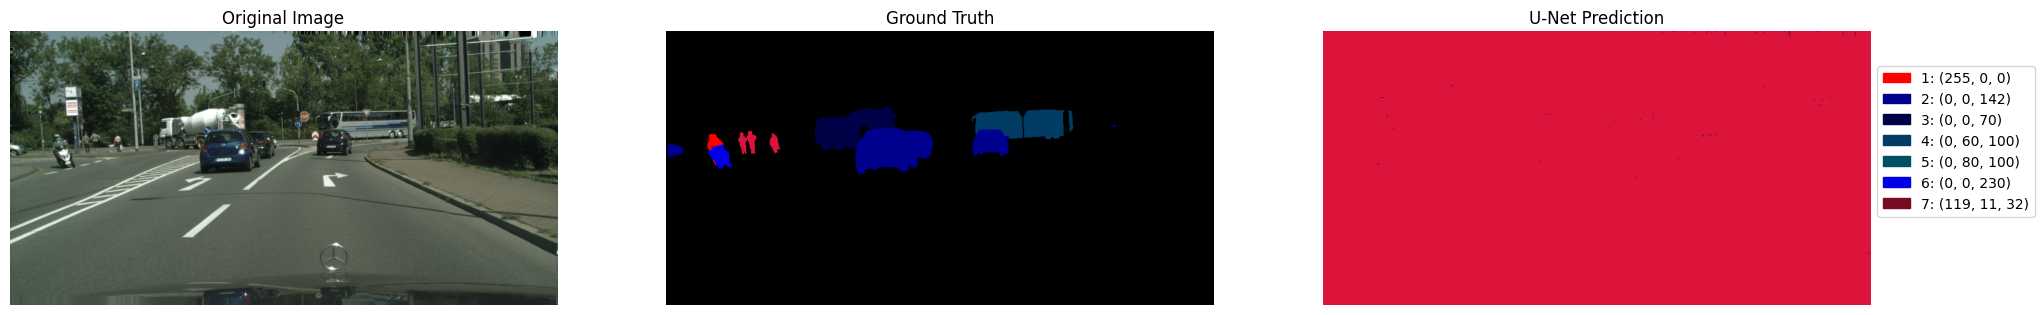

Initialized Cityscapes dataset for 'semantic' task.
Found 2975 samples in split 'train'.


In [23]:

config['device'] = 'cuda' if torch.cuda.is_available() else "cpu"
config['scaler'] = 'amp'
config['per_gpu_train_batch_size'] = 4 # if 1 gpu -> dont have to be power of 2
config['n_epochs'] = 3

model_cfg.model_name = 'UNet'
model = build_model(model_cfg, 3, 8).to(config.device)
visualize_unet(model)
train_dataset = CityscapesDataset(path_cfg, train_augmentation_unet)

 33%|███▎      | 2975/8925 [25:54<46:38,  2.13step/s, avg_loss=1.7933, ce=0.5887, current_loss=1.5465, dice=0.9078, focal=0.0499, lr=1.8e-04]

Epoch 1/4 loss: 1.7933033860178405


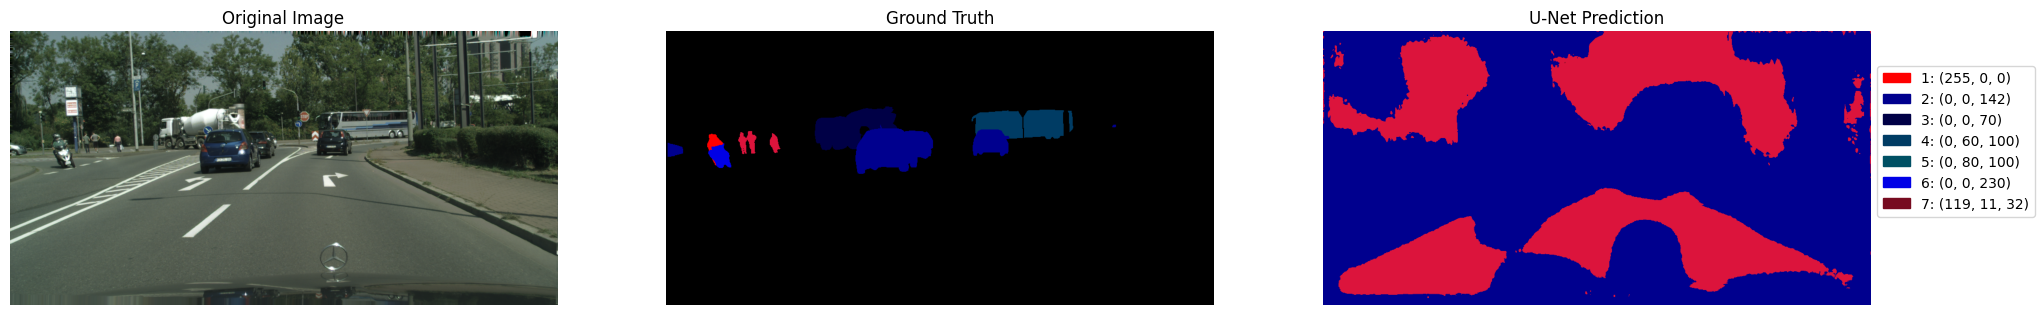

 67%|██████▋   | 5950/8925 [51:47<22:52,  2.17step/s, avg_loss=1.7075, ce=0.1618, current_loss=1.0678, dice=0.9044, focal=0.0017, lr=6.2e-05]

Epoch 2/4 loss: 1.62171169522629


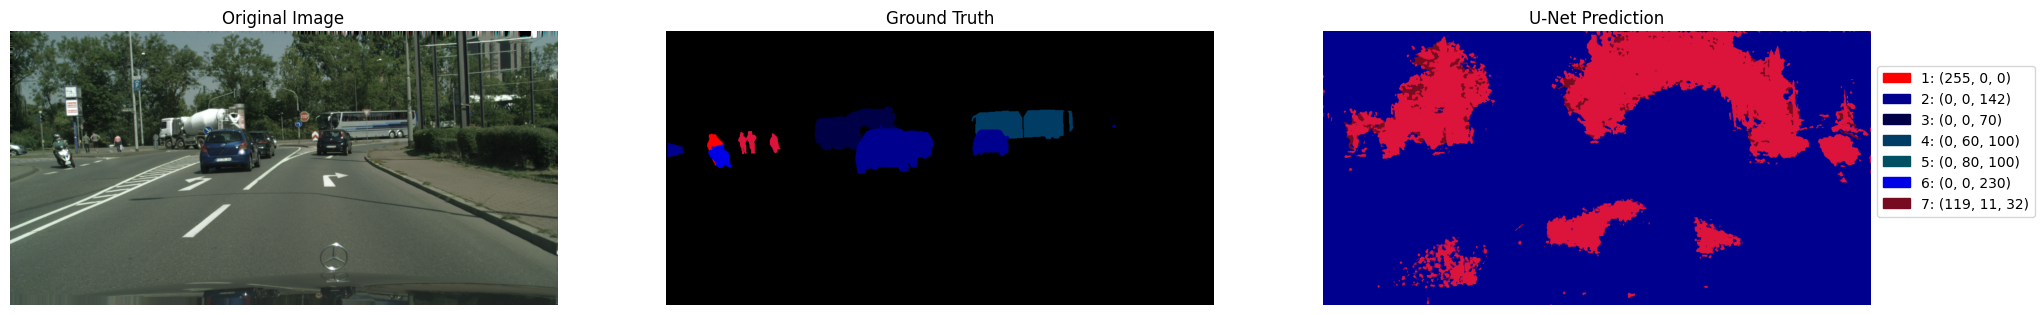

100%|██████████| 8925/8925 [1:17:35<00:00,  2.17step/s, avg_loss=1.6706, ce=0.5068, current_loss=1.4824, dice=0.9407, focal=0.0349, lr=2.2e-05]

Epoch 3/4 loss: 1.5966769747676388


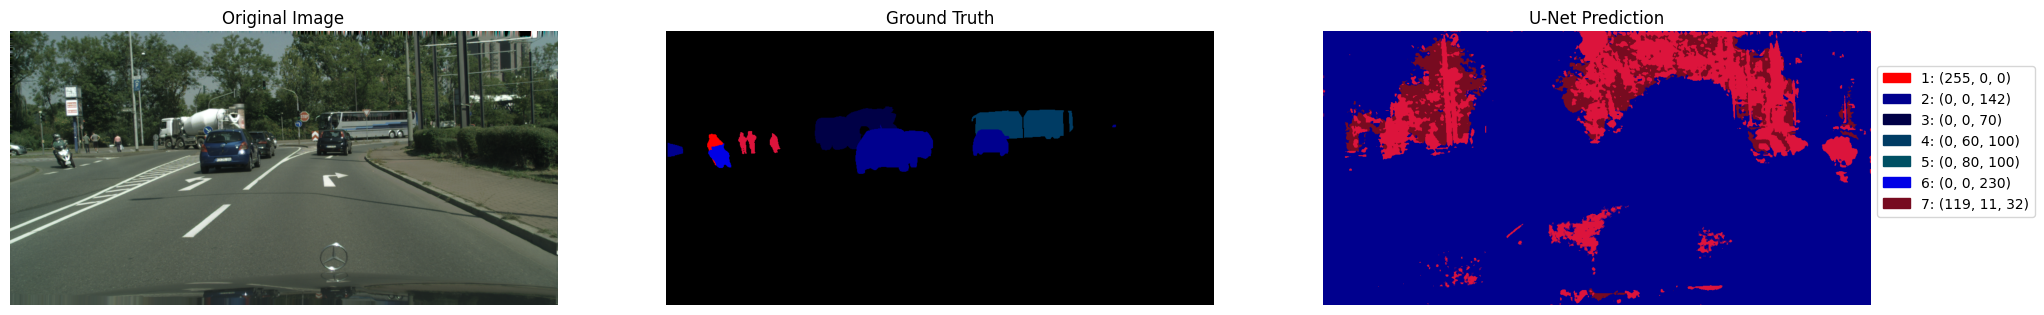

100%|██████████| 8925/8925 [1:17:36<00:00,  1.92step/s, avg_loss=1.6706, ce=0.5068, current_loss=1.4824, dice=0.9407, focal=0.0349, lr=2.2e-05]


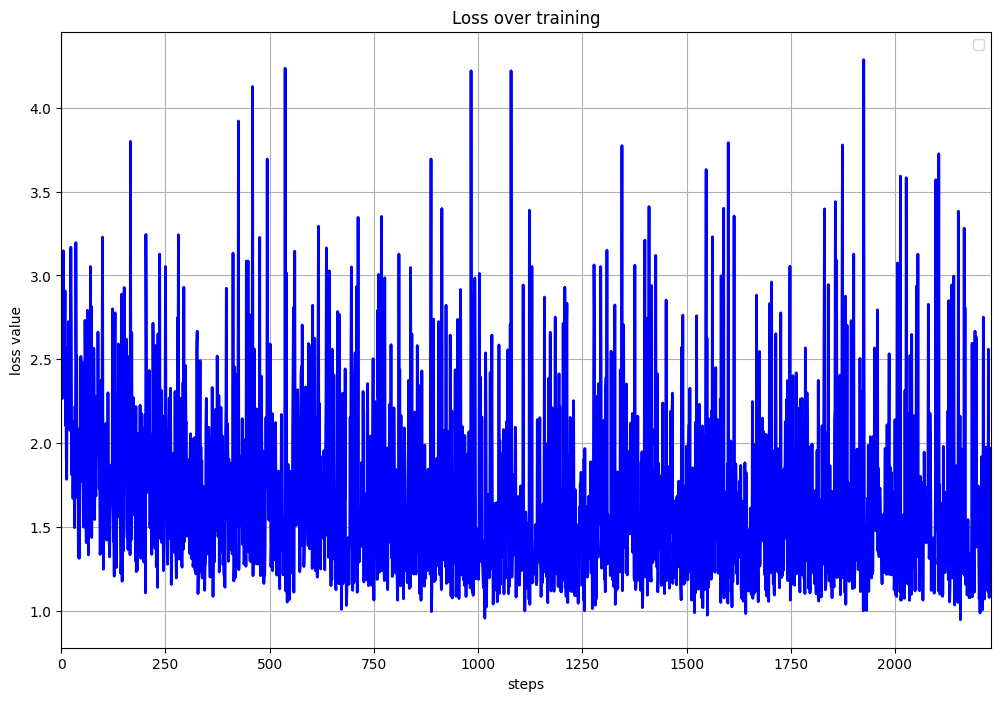

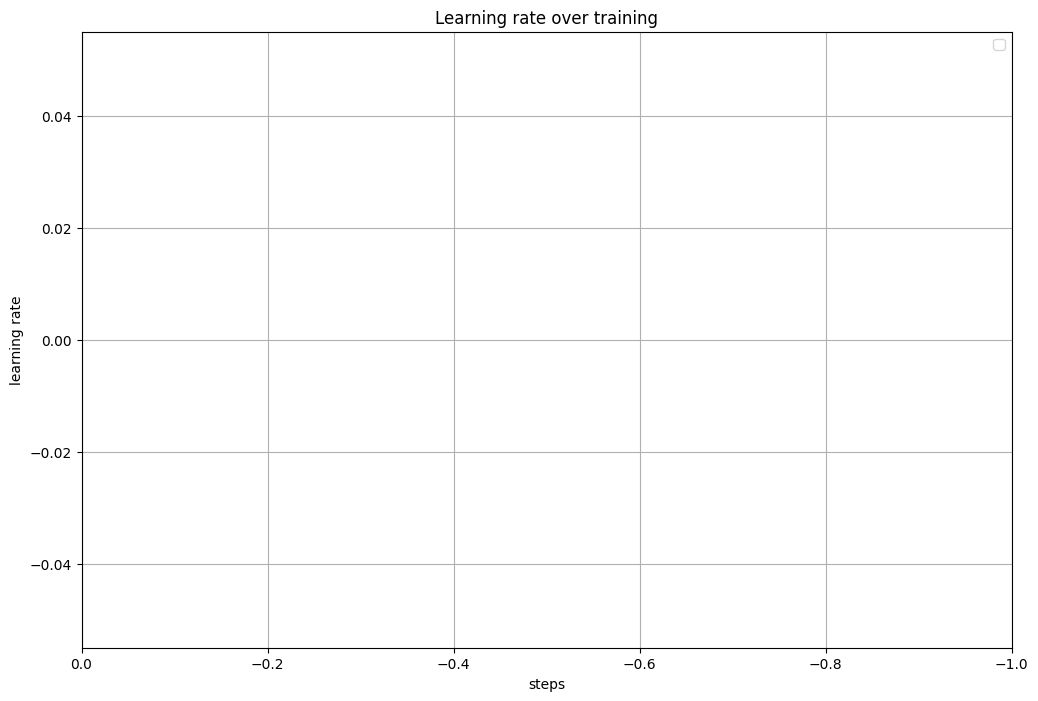

In [24]:
unet_model, step_losses = train_semantic(model, train_dataset, config)

# Validation

In [ ]:

# model_cfg.model_name = 'UNet'
# unet_model = build_model(model_cfg, 3, 9)
# weights_dict = torch.load("/kaggle/input/segmentation_cityscapes/pytorch/v01/7/UNet_9c_ckpt4epoch.pth", map_location=config.device)
# unet_model.load_state_dict(weights_dict["model_state_dict"])
# unet_model.to(config.device)
# print("Load unet complete!")

In [ ]:
class CustomMeanIoU:
    def __init__(self, num_classes: int, ignore_index: int = None, device: torch.device = None):
        """
        Custom MeanIoU metric that explicitly handles an ignore_index.

        Args:
            num_classes (int): The number of valid classes (excluding the ignore_index).
            ignore_index (int, optional): The class label to ignore in calculations. Defaults to None.
            device (torch.device, optional): The device to store internal tensors on. Defaults to None (CPU).
        """
        if num_classes <= 0:
            raise ValueError("num_classes must be a positive integer.")
        
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.device = device if device is not None else torch.device("cpu")

        # Initialize tensors to accumulate intersections and unions
        self.intersections = torch.zeros(num_classes, dtype=torch.long, device=self.device)
        self.unions = torch.zeros(num_classes, dtype=torch.long, device=self.device)
        
        # Keep track of the number of samples processed for better debug/understanding
        self._num_updates = 0

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        """
        Update the metric state with new predictions (logits) and targets (one-hot masks).

        Args:
            preds (torch.Tensor): Predicted mask logits (float tensor, shape [B, C, H, W]).
            target (torch.Tensor): Ground truth semantic masks (long/float tensor, shape [B, C, H, W] - assumed one-hot or similar).
                                   Values should represent class membership.
                                   If target is already class IDs [B, H, W], please adjust this function.
        """
        # --- 1. Convert logits to predicted class IDs [B, H, W] ---
        if preds.dim() != 4:
            raise ValueError(f"Preds must be [B, C, H, W] where C is num_classes. Got {preds.shape}")
        predicted_classes = torch.argmax(preds, dim=1).to(torch.long)

        # --- 2. Convert target from multi-channel (e.g., one-hot) to class IDs [B, H, W] ---
        if target.dim() == 4:
            if target.shape[1] != 1:
                target_classes = torch.argmax(target, dim=1).clone().to(torch.long)
            else:
                target_classes = target.squeeze(1).clone().to(torch.long) # Added .clone() for safety
        elif target.dim() == 3:
            target_classes = target.clone().to(torch.long)
        else:
            raise ValueError(
                f"Unsupported target shape or format. Expected [B, C, H, W] (one-hot), "
                f"[B, 1, H, W], or [B, H, W] (class IDs). Got {target.shape}"
            )

        if predicted_classes.shape != target_classes.shape:
            raise ValueError(
                f"Predicted and target class maps must have the same spatial shape. "
                f"Got predicted: {predicted_classes.shape} and target: {target_classes.shape}"
            )
        
        predicted_classes = predicted_classes.to(self.device)
        target_classes = target_classes.to(self.device)

        valid_mask = torch.ones_like(target_classes, dtype=torch.bool, device=self.device)
        if self.ignore_index is not None:
            valid_mask = (target_classes != self.ignore_index)

        preds_valid = predicted_classes[valid_mask]
        target_valid = target_classes[valid_mask]
        
        for c in range(self.num_classes):
            target_c = (target_valid == c)
            preds_c = (preds_valid == c)

            intersection = (preds_c & target_c).sum()
            union = (preds_c | target_c).sum()

            self.intersections[c] += intersection
            self.unions[c] += union
            
        self._num_updates += preds.shape[0]

    def compute(self) -> float:
        """
        Compute the Mean IoU based on accumulated intersections and unions.

        Returns:
            float: The Mean IoU value. Returns 0.0 if no valid pixels were processed.
        """
        ious = torch.zeros(self.num_classes, dtype=torch.float, device=self.device)

        for c in range(self.num_classes):
            if self.unions[c] > 0:
                ious[c] = self.intersections[c].float() / self.unions[c].float()
            else:
                # If a class had no ground truth or predictions in valid regions, its IoU is NaN
                # We will ignore these NaNs when computing the mean.
                ious[c] = torch.nan 

        # Filter out NaN values (classes with no occurrences) for mean calculation
        valid_ious = ious[~torch.isnan(ious)]
        # print(ious)
        if len(valid_ious) == 0:
            return 0.0
            
        mean_iou = torch.mean(valid_ious)
        return mean_iou.item()

    def reset(self):
        """
        Reset the metric state.
        """
        self.intersections = torch.zeros(self.num_classes, dtype=torch.long, device=self.device)
        self.unions = torch.zeros(self.num_classes, dtype=torch.long, device=self.device)
        self._num_updates = 0

# Original: https://github.com/matterport/Mask_RCNN
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
        
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)
    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union
    
    return overlaps

# Original: https://github.com/matterport/Mask_RCNN
def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]
    
# Original: https://github.com/matterport/Mask_RCNN
def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.1): # low score threshold
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Trim zero padding
    # TODO: cleaner to do zero unpadding upstream
    # gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    # pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    # Sort predictions by score from high to low
    indices = np.argsort(pred_scores)[::-1].copy()
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps [pred_masks, gt_masks]
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)
    # print(overlaps.shape)
    # plt.figure(figsize=(15, 18))
    # plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    # plt.colorbar()
    
    # tick_marks_gt = np.arange(len(gt_class_ids))
    # tick_marks = np.arange(len(pred_class_ids))
    # plt.xticks(tick_marks_gt, gt_class_ids, rotation=45)
    # plt.yticks(tick_marks, pred_class_ids)
    
    # # Adding text annotations
    # for i in range(overlaps.shape[0]):
    #     for j in range(overlaps.shape[1]):
    #         plt.text(j, i, format(overlaps[i, j], 'f'),
    #                  horizontalalignment="center",
    #                  color="white" if overlaps[i, j] > overlaps.max() / 2 else "black")
    
    # plt.ylabel('Predicted Label')
    # plt.xlabel('True Label')
    # plt.tight_layout()
    # plt.show()

    # Loop through predictions and find matching ground truth boxes
    match_count = 0
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove low scores
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # Do we have a match?
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps


# Original: https://github.com/matterport/Mask_RCNN
def compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).
    gt_boxes, pred_boxes : (N, 4)
    gt_class_ids, pred_class_ids : (N)
    gt_masks, pred_masks : (H, W, N)

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])
    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

# Original: https://github.com/matterport/Mask_RCNN
def compute_ap_range(gt_box, gt_class_id, gt_mask,
                     pred_box, pred_class_id, pred_score, pred_mask,
                     iou_thresholds=None, verbose=1):
    """Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
    # Default is 0.5 to 0.95 with increments of 0.05
    iou_thresholds = iou_thresholds or np.arange(0.5, 1.0, 0.05)
    
    # Compute AP over range of IoU thresholds
    AP = []
    for iou_threshold in iou_thresholds:
        ap, precisions, recalls, overlaps =\
            compute_ap(gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        iou_threshold=iou_threshold)
        if verbose:
            print("AP @{:.2f}:\t {:.3f}".format(iou_threshold, ap))
        AP.append(ap)
    AP = np.array(AP).mean()
    if verbose:
        print("AP @{:.2f}-{:.2f}:\t {:.3f}".format(
            iou_thresholds[0], iou_thresholds[-1], AP))
    return AP

In [ ]:
def evaluate_unet_model(model, dataloader, device, num_classes, mIoU_metric):
    """
    Correctly evaluates a U-Net model using MeanIoU, ignoring the class index 255.
    """
    print('Evaluating U-Net model with MeanIoU...')
    model.eval()

    cnt = 0
    mAP = 0.0
    mAP50 = 0.0
    no_lbl_8c = 0
    with torch.no_grad():
        with tqdm(desc="Evaluating U-Net", total=len(dataloader), leave=False) as pbar:
            for images, targets in dataloader:
                images = torch.stack(images).to(device) # [B, 3, H, W]
                cnt += len(images)     
                semantic_masks = [convert_instance_to_semantic(t['masks'], t['labels']) for t in targets]
                semantic_masks = torch.stack(semantic_masks).squeeze(1) # [B, H, W]

                predicted_masks = model(images) # [B, 19, H, W]
                # ===================================================== Calculate mIoU ====================================================
                onehot_masks = torch.zeros((semantic_masks.shape[0], num_classes, semantic_masks.shape[1], semantic_masks.shape[2]), dtype=torch.long)
                for i in range(semantic_masks.shape[0]):
                    if targets[i]['labels'].shape[0] == 1: # exist image without person or vehicle
                        continue
                    unique_classes_in_this_mask = torch.unique(semantic_masks[i])
                    for class_id in range(num_classes):
                        if class_id in unique_classes_in_this_mask:
                            onehot_masks[i, class_id, :, :] = (semantic_masks[i] == class_id).long()

                mIoU_metric.update(predicted_masks.long().cpu(), onehot_masks.long().cpu())

                # ===================================================== Calculate mAP =====================================================
                pred_boxes = np.zeros((num_classes, 4)) # dummy mAP doesnt process what inside
                pred_scores = np.full(num_classes, 1.0) # assume model is sure about the mask
                pred_labels = np.arange(num_classes)
                for i in range(len(predicted_masks)):
                    if targets[i]['labels'].shape[0] == 1: # exist image without person or vehicle
                        print(targets[i]['labels'])
                        no_lbl_8c += 1
                        continue
                    target_mask = targets[i]['masks'][:-1, ...].to('cpu').permute(1, 2, 0)
                    target_mask = np.array(target_mask).astype(bool)
                    
                    targets[i] = {k: np.array(v[:-1, ...].to('cpu')) for k, v in targets[i].items()}

                    pred_masks = (predicted_masks[i] > 0.5).to('cpu').permute(1, 2, 0)
                    pred_masks = np.array(pred_masks)
                    mAP50 += compute_ap_range(targets[i]['boxes'], targets[i]['labels'], target_mask,
                                        pred_boxes, pred_labels, pred_scores, pred_masks,
                                        iou_thresholds=[0.5], verbose=0)
                    
                    mAP += compute_ap_range(targets[i]['boxes'], targets[i]['labels'], target_mask,
                                        pred_boxes, pred_labels, pred_scores, pred_masks,
                                        iou_thresholds=None, verbose=0)
                    
                pbar.update(1)
                pbar.set_postfix(iou=f"{mIoU_metric.compute():.4f}", mAP50=f"{mAP50/(cnt - no_lbl_8c):.4f}", mAP=f"{mAP/(cnt - no_lbl_8c):.4f}")
                # break

    val_miou = mIoU_metric.compute()
    mAP50 /= (cnt - no_lbl_8c)
    mAP /= (cnt - no_lbl_8c)
    model.train()
    return val_miou, mAP50, mAP

In [ ]:


val_dataset = CityscapesDataset(path_cfg, val_augmentation_unet, split='val')
config['per_gpu_eval_batch_size'] = 4
val_dataloader = get_dataloader(val_dataset, config, is_train=False)
mIoU_metric = CustomMeanIoU(num_classes=8, ignore_index=255)
UNet_val_miou, UNet_val_mAP50, UNet_val_mAP = evaluate_unet_model(unet_model, val_dataloader, config.device, 8, mIoU_metric)
print(UNet_val_miou)
print(UNet_val_mAP50, UNet_val_mAP)

In [ ]:
"""
Loads a sample, runs inference, and displays the original image,
ground truth mask, and predicted mask side-by-side.
"""
test_dataset_for_viz = CityscapesDataset(path_cfg, val_augmentation_unet, split='train')
image_idx_to_viz = np.random.randint(0, len(test_dataset_for_viz)-1)
original_image_viz = read_image(test_dataset_for_viz.images[image_idx_to_viz]).to(torch.uint8)

unet_model.eval()
with torch.no_grad():
    image_tensor, target_dict = test_dataset_for_viz[image_idx_to_viz]
    
    gt_instance_masks = target_dict['masks']
    gt_instance_labels = target_dict['labels']
    
    gt_semantic_mask = convert_instance_to_semantic(gt_instance_masks, gt_instance_labels)

    input_tensor = image_tensor.unsqueeze(0).to(config.device)
    logits = unet_model(input_tensor)
    
    pred_semantic_mask = torch.argmax(logits.squeeze(0), dim=0).cpu()

gt_color_mask = colorize_mask(gt_semantic_mask, class_trainId_to_color)
pred_color_mask = colorize_mask(pred_semantic_mask, class_trainId_to_color)

plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.imshow(original_image_viz.permute(1, 2, 0))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_color_mask.permute(1, 2, 0))
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_color_mask.permute(1, 2, 0))
plt.title("U-Net Prediction")
plt.axis('off')

plt.show()